This notebook will compare the metadata files created by the SPGC and the pg_catalog.csv from project gutenberg
Then, it will make a dataset

In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob

from collections import Counter
import matplotlib.pyplot as plt

import misc_utils.dataset_filtering as dataset_filtering

In [4]:
git_repo_path = '/home/dean/Documents/gitRepos'
gutenberg_repo_path = os.path.join(git_repo_path, 'gutenberg')
gutenberg_analysis_repo = os.path.join(git_repo_path, 'gutenberg-analysis')

In [5]:
## import internal helper functions
analysis_src_dir = os.path.join(gutenberg_analysis_repo,'src')
sys.path.append(analysis_src_dir)
from data_io import get_book

gutenberg_src_dir = os.path.join(gutenberg_repo_path,'src')
sys.path.append(gutenberg_src_dir)

from metaquery import meta_query
from jsd import jsdalpha

# Read in both metadata files

In [6]:
mq_filepath=os.path.join(gutenberg_repo_path,'metadata','metadata.csv')
pg_catalog_filepath=os.path.join(git_repo_path, 'gutenberg_corpus_analysis', 'sample_dataset', 'pg_catalog.csv')

# Load both  metadata files

Load both the metadata file generated by SPGC and the metadata file from PG

In [12]:
df = dataset_filtering.read_metadata_and_catalog(mq_filepath, pg_catalog_filepath)
original_shape=df.shape

Get only English books, according to PG catalog

In [13]:
df = df.query('Language=="en"')
df['Language'].unique()

array(['en'], dtype=object)

Let's verify that the language column in both metadata files match

In [14]:
df['language'].unique()

array(["['en']"], dtype=object)

Uh oh, it doesn't!  What book is this causing the problems?

In [11]:
df.query('Language=="en" and language=="[\'ne\']"')

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,PG_ID,type_pgc,title_pgc,Language,Authors,Subjects,LoCC,Bookshelves


Lets get rid of it!

In [9]:
index_to_drop = df.query('Language=="en" and language=="[\'ne\']"').index
df.drop(index_to_drop, inplace=True)

In [15]:
# Verifying that everything is good
print(df['Language'].unique())
print(df['language'].unique())

['en']
["['en']"]


In [16]:
print(f'Original Shape: {original_shape}')
print(f'Current Shape: {df.shape}')

Original Shape: (74373, 17)
Current Shape: (59116, 17)


# Lets get rid of anything missing a title or an author

In [18]:
tdf = df[['title', 'title_pgc', 'author', 'Authors']]
tdf[tdf.isnull().any(axis=1)]

,title,title_pgc,author,Authors
30,Spalding's Official Baseball Guide - 1913,Spalding's Official Baseball Guide - 1913,NaN,"Foster, John B. (John Buckingham), 1863-1941 [..."
93,Moorish Literature: Comprising Romantic Ballad...,Moorish Literature\r\nComprising Romantic Ball...,NaN,"Basset, René, 1855-1924 [Editor]"
114,"The Great Events by Famous Historians, Volume ...","The Great Events by Famous Historians, Volume ...",NaN,"Johnson, Rossiter, 1840-1931 [Editor]; Horne, ..."
126,"The Great Events by Famous Historians, Volume ...","The Great Events by Famous Historians, Volume ...",NaN,"Johnson, Rossiter, 1840-1931 [Editor]; Horne, ..."
134,The Literature of Arabia: With Critical and Bi...,The Literature of Arabia\r\nWith Critical and ...,NaN,"Wilson, Epiphanius, 1845-1916 [Editor]"
...,...,...,...,...
75458,Who Was Who: 5000 B. C. to Date: Biographical ...,Who Was Who: 5000 B. C. to Date\r\nBiographica...,NaN,"Gordon, Irwin Leslie, 1888-1954 [Editor]"
75532,Spalding's Baseball Guide and Official League ...,Spalding's Baseball Guide and Official League ...,NaN,"Chadwick, Henry, 1824-1908 [Editor]"
75537,The Garden of Bright Waters: One Hundred and T...,The Garden of Bright Waters\r\nOne Hundred and...,NaN,"Mathers, E. Powys (Edward Powys), 1892-1939 [T..."
75546,"The Great Events by Famous Historians, Volume 12","The Great Events by Famous Historians, Volume 12",NaN,"Johnson, Rossiter, 1840-1931 [Editor]; Horne, ..."


Well, it looks like most of these HAVE authors (or at least editors), it's just messed up in the metadata created by SPGC.  Let's just drop them.

In [19]:
tdf.head()

,title,title_pgc,author,Authors
0,The Magna Carta,The Magna Carta,Anonymous,Anonymous
1,Apocolocyntosis,Apocolocyntosis,"Seneca, Lucius Annaeus","Seneca, Lucius Annaeus, 5? BCE-65; Rouse, W. H..."
2,The House on the Borderland,The House on the Borderland,"Hodgson, William Hope","Hodgson, William Hope, 1877-1918"
3,"My First Years as a Frenchwoman, 1876-1879","My First Years as a Frenchwoman, 1876-1879","Waddington, Mary King","Waddington, Mary King, 1833-1923"
4,The Warriors,The Warriors,"Lindsay, Anna Robertson Brown","Lindsay, Anna Robertson Brown, 1864-1948"


In [20]:
to_drop = tdf[tdf.isnull().any(axis=1)].index
df.loc[to_drop].head()

,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,PG_ID,type_pgc,title_pgc,Language,Authors,Subjects,LoCC,Bookshelves
30,PG10028,Spalding's Official Baseball Guide - 1913,NaN,NaN,NaN,['en'],118,{'Baseball'},Text,10028,Text,Spalding's Official Baseball Guide - 1913,en,"Foster, John B. (John Buckingham), 1863-1941 [...",Baseball,GV,Browsing: Sports/Hobbies/Motoring
93,PG10085,Moorish Literature: Comprising Romantic Ballad...,NaN,NaN,NaN,['en'],202,{'Spanish literature -- Translations into Engl...,Text,10085,Text,Moorish Literature\r\nComprising Romantic Ball...,en,"Basset, René, 1855-1924 [Editor]",Spanish literature -- Translations into English,PQ,Browsing: Literature
114,PG10103,"The Great Events by Famous Historians, Volume ...",NaN,NaN,NaN,['en'],207,{'World history'},Text,10103,Text,"The Great Events by Famous Historians, Volume ...",en,"Johnson, Rossiter, 1840-1931 [Editor]; Horne, ...",World history,D,Browsing: History - European; Browsing: Histor...
126,PG10114,"The Great Events by Famous Historians, Volume ...",NaN,NaN,NaN,['en'],327,{'World history'},Text,10114,Text,"The Great Events by Famous Historians, Volume ...",en,"Johnson, Rossiter, 1840-1931 [Editor]; Horne, ...",World history,D,Greece; Browsing: History - European; Browsing...
134,PG10121,The Literature of Arabia: With Critical and Bi...,NaN,NaN,NaN,['en'],116,{'Arabic literature'},Text,10121,Text,The Literature of Arabia\r\nWith Critical and ...,en,"Wilson, Epiphanius, 1845-1916 [Editor]",Arabic literature,PJ,Browsing: Culture/Civilization/Society; Browsi...


In [21]:
df.drop(to_drop, inplace=True)

# Lets see if titles match

In [22]:
dont_match, attribute_errors = dataset_filtering.compare_columns(df, 'title', 'title_pgc', verbose=True)#['author']

Dont Match: id: PG29801   A Short History of EBooks   A History of EBooks
Dont Match: id: PG59774   Thirty Strange Stories   30 Strange Stories
Dont Match: id: PG63765   The Divine and Perpetual Obligation of the Observance of the Sabbath, with Reference more Especially to a Pamphlet Lately Puvblished by the Rev. C.J. Vaughan, D.D., Head Master of Harrow School, Entitled “A Few Words on the Crystal Palace Question”   Mutiny
Dont Match: id: PG6420   Copyright Renewals 1960   U.S. Copyright Renewals, 1960


Let's get rid of PG63765 and lets note that we should get rid of copyright renewals en masse.

We can also ditch the duplicate column

In [23]:
df = df[df['id']!='PG63765']
df.drop('title_pgc', axis=1, inplace=True)

# Verify Author Matches

In [24]:
dont_match, attribute_errors = dataset_filtering.compare_columns(df, 'author', 'Authors')
dont_match[['title','author','Authors']]

,title,author,Authors
1,Apocolocyntosis,"Seneca, Lucius Annaeus","Seneca, Lucius Annaeus, 5? BCE-65; Rouse, W. H..."
2,The House on the Borderland,"Hodgson, William Hope","Hodgson, William Hope, 1877-1918"
3,"My First Years as a Frenchwoman, 1876-1879","Waddington, Mary King","Waddington, Mary King, 1833-1923"
4,The Warriors,"Lindsay, Anna Robertson Brown","Lindsay, Anna Robertson Brown, 1864-1948"
5,A Voyage to the Moon: With Some Account of the...,"Tucker, George","Tucker, George, 1775-1861"
...,...,...,...
75621,"France and England in North America, Part III:...","Parkman, Francis","Parkman, Francis, 1823-1893"
75622,Poems,"Betham, Matilda","Betham, Matilda, 1776-1852"
75623,"Harriet, the Moses of Her People","Bradford, Sarah H. (Sarah Hopkins)","Bradford, Sarah H. (Sarah Hopkins), 1818-1912"
75625,Collected Articles of Frederick Douglass,"Douglass, Frederick","Douglass, Frederick, 1818-1895"


Note that there are actually a bunch that don't match properly, but it appears that it is mostly a formatting issue.  We can come back to it, if needed.  Leaving them here

Lets ditch the duplicate authors column though

In [25]:
df.drop('Authors', axis=1, inplace=True)

# Do IDs match?  They better!

Note: This should be totally unnecessary since we joined on ID

In [26]:
# Create a numeric version of the 'id' column with the "PG" removed
df['id_numeric'] = (
    df['id']
    .str.replace('PG', '')  # remove the literal "PG"
    .astype(str)            # convert to integer
)

df['PG_ID'] = df['PG_ID'].astype(str)              # Convert numeric to string

dont_match, attribute_errors = dataset_filtering.compare_columns(
    df,
    'id_numeric',
    'PG_ID',
    verbose=True
)

In [27]:
print(dont_match)
print(attribute_errors)

Empty DataFrame
Columns: [id, title, author, authoryearofbirth, authoryearofdeath, language, downloads, subjects, type, PG_ID, type_pgc, Language, Subjects, LoCC, Bookshelves, id_numeric]
Index: []
[]


No entries show up with unmatching id's. We can drop the placeholder id_numeric column. I keep the redundant PG_ID column here not knowing if it will be useful later to query the raw data. 

# Where do we stand?

In [29]:
df.shape

(56836, 16)

In [30]:
df.columns

Index(['id', 'title', 'author', 'authoryearofbirth', 'authoryearofdeath',
       'language', 'downloads', 'subjects', 'type', 'PG_ID', 'type_pgc',
       'Language', 'Subjects', 'LoCC', 'Bookshelves', 'id_numeric'],
      dtype='object')

# Add information on the length of books

Adds the number of lines, the number of words, and the number of unique words

By default, drops the books you haven't downloaded

#### Add the total word count of the entry, called 'word_count'.

In [31]:
count_path = os.path.join(gutenberg_repo_path, 'data', 'counts')
df['word_count'] = df['id'].apply(lambda pid: dataset_filtering.get_word_count(pid, count_path))

#### Add the total unique word count of the entry, called 'unique_word_count'.

In [32]:


count_path = os.path.join(gutenberg_repo_path, 'data', 'counts')
df['unique_word_count'] = df['id'].apply(
    lambda pid: dataset_filtering.get_unique_word_count(pid, count_path)
)

#### Add total lines of text in the raw text file, called 'line_count'.

Note that this is taking line count of the somewhat-cleaned files in the text folder, not the files in the raw folder.

In [33]:


text_path = os.path.join(gutenberg_repo_path, 'data', 'text')
df['line_count'] = df['id'].apply(
    lambda pid: dataset_filtering.get_line_count(pid, text_path)
)

#### Add total tokens in the entry, called 'token_count'.

In [34]:


token_path = os.path.join(gutenberg_repo_path, 'data', 'tokens')
df['token_count'] = df['id'].apply(
    lambda pid: dataset_filtering.get_token_count(pid, token_path)
)

In [35]:
df.shape

(56836, 20)

In [36]:
outfile = 'merged_with_missing_books_and_counts.csv'
df.to_csv(outfile)

# Drop Missing Books

In [122]:
df = pd.read_csv(outfile)

In [123]:
# Drop rows with NaN values in the line_count column
df.dropna(subset=['line_count'], inplace=True)
df.shape

(34902, 21)

# Looking at Authors

In [124]:
df['author'].value_counts()

author
Various                                2218
Anonymous                               396
Oliphant, Mrs. (Margaret)               132
Jacobs, W. W. (William Wymark)          110
Shakespeare, William                    106
                                       ... 
Lightfoot, J. B. (Joseph Barber)          1
Lybyer, Albert Howe                       1
Murray, John                              1
Ajax                                      1
Blancké, Wilton W. (Wilton Wallace)       1
Name: count, Length: 14098, dtype: int64

It will be difficult to categorize "Various", "Anonymous", or "Unknown" authors, let's ditch them

In [125]:
df = df[~df['author'].isin(['Various', 'Anonymous', 'Unknown'])]
df.shape

(32244, 21)

Lets see how many authors have more than 10 or 20 books

In [126]:
vc = df['author'].value_counts()
vc

author
Oliphant, Mrs. (Margaret)                    132
Jacobs, W. W. (William Wymark)               110
Shakespeare, William                         106
Balzac, Honoré de                             99
Alger, Horatio, Jr.                           74
                                            ... 
Reynolds, Robert Rice                          1
McGregor, Richard C. (Richard Crittenden)      1
Grazebrook, George                             1
Marten, Edward Bindon                          1
Blancké, Wilton W. (Wilton Wallace)            1
Name: count, Length: 14095, dtype: int64

In [ ]:
def get_author_stats(df, author):
    """
    Get the statistics for a given author.
    """
    tdf = df[df['author'] == author]
    total_books = tdf.shape[0]
    total_lines = tdf['line_count'].sum()
    total_words = tdf['word_count'].sum()
    total_tokens = tdf['token_count'].sum()
    total_unique_words = tdf['unique_word_count'].sum()
    return total_books, total_lines, total_words, total_tokens, total_unique_words

In [138]:
author_stats={}
for author, tdf in df.groupby('author'):
    total_books, total_lines, total_words, total_tokens, total_unique_words = get_author_stats(df, author)
    author_stats[author] = {
        'total_books': total_books,
        'total_lines': total_lines,
        'total_words': total_words,
        'total_tokens': total_tokens,
        'total_unique_words': total_unique_words
    }
    print(f'{author:30}   books: {total_books:5} lines: {total_lines:10}   words: {total_words:10}   tokens: {total_tokens:10}   unique words: {total_unique_words:10}')
    #print(f'{author:30}   books: {df.shape[1]} )

A British officer                books:     1 lines:    10973.0   words:   103518.0   tokens:   103518.0   unique words:     9324.0
A Californian                    books:     1 lines:    13571.0   words:   105353.0   tokens:   105353.0   unique words:     8204.0
A lady                           books:     1 lines:    11742.0   words:   107618.0   tokens:   107618.0   unique words:     9656.0
A-No. 1                          books:     1 lines:     4042.0   words:    41118.0   tokens:    41118.0   unique words:     5123.0
A. L. O. E.                      books:    33 lines:   128879.0   words:  1071713.0   tokens:  1071713.0   unique words:   131745.0
Aandahl, Vance                   books:     1 lines:      236.0   words:     1472.0   tokens:     1472.0   unique words:      603.0
Aaronsohn, Alexander             books:     1 lines:     1924.0   words:    18032.0   tokens:    18032.0   unique words:     3522.0
Abbot, Robert, cook              books:     1 lines:     2381.0   words:    

In [139]:
author_stat_df = df.from_dict(author_stats, orient='index')
author_stat_df

,total_books,total_lines,total_words,total_tokens,total_unique_words
A British officer,1,10973.0,103518.0,103518.0,9324.0
A Californian,1,13571.0,105353.0,105353.0,8204.0
A lady,1,11742.0,107618.0,107618.0,9656.0
A-No. 1,1,4042.0,41118.0,41118.0,5123.0
A. L. O. E.,33,128879.0,1071713.0,1071713.0,131745.0
...,...,...,...,...,...
"dePina, Albert",7,13363.0,109886.0,109886.0,21631.0
"À Beckett, Gilbert Abbott",2,39889.0,408539.0,408539.0,27102.0
Çerkesseyhizade Halil Halit,1,5016.0,51801.0,51801.0,6113.0
"Čapek, Karel",2,7101.0,28917.0,28917.0,4459.0


In [140]:
print(f'There are a total of {len(vc)} authors')
for book_count in [10, 20, 30, 40, 50, 75, 100]:
    print(f'There are {len(vc[vc >= book_count])} authors with more than {book_count} books')


There are a total of 14095 authors
There are 521 authors with more than 10 books
There are 166 authors with more than 20 books
There are 80 authors with more than 30 books
There are 45 authors with more than 40 books
There are 22 authors with more than 50 books
There are 4 authors with more than 75 books
There are 3 authors with more than 100 books


In [145]:
for i in range(10000, 100001, 10000):
    print(i)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [156]:
author_stat_df

,total_books,total_lines,total_words,total_tokens,total_unique_words
A British officer,1,10973.0,103518.0,103518.0,9324.0
A Californian,1,13571.0,105353.0,105353.0,8204.0
A lady,1,11742.0,107618.0,107618.0,9656.0
A-No. 1,1,4042.0,41118.0,41118.0,5123.0
A. L. O. E.,33,128879.0,1071713.0,1071713.0,131745.0
...,...,...,...,...,...
"dePina, Albert",7,13363.0,109886.0,109886.0,21631.0
"À Beckett, Gilbert Abbott",2,39889.0,408539.0,408539.0,27102.0
Çerkesseyhizade Halil Halit,1,5016.0,51801.0,51801.0,6113.0
"Čapek, Karel",2,7101.0,28917.0,28917.0,4459.0


In [175]:
print(f'There are a total of {len(vc)} authors')
for min_word in range(10000, 500001, 20000):
    author_count = len(author_stat_df.query('total_words > @min_word'))
    print(f'There are {author_count} authors with more than {min_word} words')


There are a total of 14095 authors
There are 7948 authors with more than 10000 words
There are 7948 authors with more than 30000 words
There are 7947 authors with more than 50000 words
There are 6317 authors with more than 70000 words
There are 5046 authors with more than 90000 words
There are 4123 authors with more than 110000 words
There are 3480 authors with more than 130000 words
There are 2977 authors with more than 150000 words
There are 2561 authors with more than 170000 words
There are 2258 authors with more than 190000 words
There are 1996 authors with more than 210000 words
There are 1791 authors with more than 230000 words
There are 1619 authors with more than 250000 words
There are 1503 authors with more than 270000 words
There are 1386 authors with more than 290000 words
There are 1289 authors with more than 310000 words
There are 1195 authors with more than 330000 words
There are 1126 authors with more than 350000 words
There are 1065 authors with more than 370000 words
T

To get a better sense of the distribution, lets just drop every author with fewer than 10,000 words

In [165]:
# Drop the authors with less than 10000 words
min_word = 50000
authors_to_drop = author_stat_df.query('total_words < @min_word').index.unique()
df = df[~df['author'].isin(authors_to_drop)]
df.shape

(25181, 21)

In [166]:
author_stats={}
for author, tdf in df.groupby('author'):
    total_books, total_lines, total_words, total_tokens, total_unique_words = get_author_stats(df, author)
    author_stats[author] = {
        'total_books': total_books,
        'total_lines': total_lines,
        'total_words': total_words,
        'total_tokens': total_tokens,
        'total_unique_words': total_unique_words
    }
   # print(f'{author:30}   books: {total_books:5} lines: {total_lines:10}   words: {total_words:10}   tokens: {total_tokens:10}   unique words: {total_unique_words:10}')
    #print(f'{author:30}   books: {df.shape[1]} )

In [167]:
author_stat_df = df.from_dict(author_stats, orient='index')
author_stat_df

,total_books,total_lines,total_words,total_tokens,total_unique_words
A British officer,1,10973.0,103518.0,103518.0,9324.0
A Californian,1,13571.0,105353.0,105353.0,8204.0
A lady,1,11742.0,107618.0,107618.0,9656.0
A. L. O. E.,33,128879.0,1071713.0,1071713.0,131745.0
"Abbot, Willis J. (Willis John)",2,31635.0,272876.0,272876.0,22328.0
...,...,...,...,...,...
"Zwilgmeyer, Dikken",2,9655.0,68840.0,68840.0,6658.0
"dePina, Albert",7,13363.0,109886.0,109886.0,21631.0
"À Beckett, Gilbert Abbott",2,39889.0,408539.0,408539.0,27102.0
Çerkesseyhizade Halil Halit,1,5016.0,51801.0,51801.0,6113.0


Lets find the minimum number of books any author has, given that they have 100,000 words

In [186]:
num_words = 750000
author_stat_df.query('total_words > @num_words')#.value_counts('total_books')

,total_books,total_lines,total_words,total_tokens,total_unique_words
A. L. O. E.,33,128879.0,1071713.0,1071713.0,131745.0
"Abbott, Jacob",18,95474.0,847911.0,847911.0,68834.0
"Abbott, John S. C. (John Stevens Cabot)",10,102819.0,909936.0,909936.0,77382.0
"Adams, Henry",12,156246.0,1311896.0,1311896.0,96464.0
"Addison, Joseph",4,178167.0,1396769.0,1396769.0,65296.0
...,...,...,...,...,...
"Yonge, Charlotte M. (Charlotte Mary)",34,477012.0,3886008.0,3886008.0,283368.0
"Young, Clarence",24,167170.0,1137847.0,1137847.0,101452.0
"Zangwill, Israel",7,118590.0,955003.0,955003.0,90653.0
"Zola, Émile",38,590538.0,5658754.0,5658754.0,341974.0


In [170]:
author_stat_df.value_counts('total_books')

total_books
1      4418
2      1396
3       606
4       340
5       235
       ... 
55        1
54        1
48        1
31        1
132       1
Name: count, Length: 67, dtype: int64

In [196]:
def plot_author_stat_distribution(df, stat, title):
    """
    Plot the distribution of a given statistic for all authors.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df[stat], bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel(stat)
    plt.ylabel('Number of Authors')
    plt.grid()
    plt.show()

def plot_all_author_stat_distributions(df):
    """
    Plot the distribution of all author statistics.
    """
    stats = ['total_books', 'total_lines', 'total_words', 'total_tokens', 'total_unique_words']
    titles = [
        'Distribution of Total Books by Author',
        'Distribution of Total Lines by Author',
        'Distribution of Total Words by Author',
        'Distribution of Total Tokens by Author',
        'Distribution of Total Unique Words by Author'
    ]
    
    for stat, title in zip(stats, titles):
        plot_author_stat_distribution(df, stat, title)
    

Let's get rid of all authors with under 1000 total 

In [188]:
def drop_authors_with_fewer_than(df, author_stat_df, min_count, column):
    """
    Drop authors with fewer than a given count of (books, lines, words, tokens, unique words)
    """
    author_stat_df = author_stat_df.copy()
    df = df.copy()
    # Drop authors with fewer than min_count (books, lines, words, tokens, unique words)
    authors_to_drop = author_stat_df.query(f'{column} < @min_count').index.unique()
    df = df[~df['author'].isin(authors_to_drop)]
    author_stat_df.drop(authors_to_drop, inplace=True)
    return df, author_stat_df

In [192]:
author_stat_df

,total_books,total_lines,total_words,total_tokens,total_unique_words
A British officer,1,10973.0,103518.0,103518.0,9324.0
A Californian,1,13571.0,105353.0,105353.0,8204.0
A lady,1,11742.0,107618.0,107618.0,9656.0
A. L. O. E.,33,128879.0,1071713.0,1071713.0,131745.0
"Abbot, Willis J. (Willis John)",2,31635.0,272876.0,272876.0,22328.0
...,...,...,...,...,...
"Zwilgmeyer, Dikken",2,9655.0,68840.0,68840.0,6658.0
"dePina, Albert",7,13363.0,109886.0,109886.0,21631.0
"À Beckett, Gilbert Abbott",2,39889.0,408539.0,408539.0,27102.0
Çerkesseyhizade Halil Halit,1,5016.0,51801.0,51801.0,6113.0


In [200]:
df2, author_stat_df2 = drop_authors_with_fewer_than(df, author_stat_df, 1000000, 'total_words')
df2

,Unnamed: 0,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,...,type_pgc,Language,Subjects,LoCC,Bookshelves,id_numeric,word_count,unique_word_count,line_count,token_count
7,7,PG10007,Carmilla,"Le Fanu, Joseph Sheridan",1814.0,1873.0,['en'],10573,"{'Young women -- Fiction', 'Vampires -- Fiction'}",Text,...,Text,en,Young women -- Fiction; Vampires -- Fiction,PR,Horror; Gothic Fiction; Browsing: Gender & Sex...,10007,27281.0,3918.0,3345.0,27281.0
20,21,PG1001,"Divine Comedy, Longfellow's Translation, Hell",Dante Alighieri,1265.0,1321.0,['en'],4183,"{'Hell -- Poetry', 'Epic poetry, Italian -- Tr...",Text,...,Text,en,"Hell -- Poetry; Epic poetry, Italian -- Transl...",PQ,Italy; Browsing: History - European; Browsing:...,1001,36961.0,5122.0,6566.0,36961.0
30,32,PG1002,"Divine Comedy, Longfellow's Translation, Purga...",Dante Alighieri,1265.0,1321.0,['en'],508,"{'Epic poetry, Italian -- Translations into En...",Text,...,Text,en,"Epic poetry, Italian -- Translations into Engl...",PQ,Italy; Browsing: Culture/Civilization/Society;...,1002,36788.0,5030.0,6615.0,36788.0
32,34,PG10031,The Complete Poetical Works of Edgar Allan Poe...,"Poe, Edgar Allan",1809.0,1849.0,['en'],1351,"{'Fantasy poetry, American'}",Text,...,Text,en,"Fantasy poetry, American",PS,Browsing: History - American; Browsing: Litera...,10031,59726.0,7828.0,9938.0,59726.0
41,43,PG1003,"Divine Comedy, Longfellow's Translation, Paradise",Dante Alighieri,1265.0,1321.0,['en'],575,"{'Epic poetry, Italian -- Translations into En...",Text,...,Text,en,"Epic poetry, Italian -- Translations into Engl...",PQ,Italy; Browsing: Culture/Civilization/Society;...,1003,36996.0,5147.0,6728.0,36996.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56700,75469,PG985,Father Sergius,"Tolstoy, Leo, graf",1828.0,1910.0,['en'],656,"{'Monasteries -- Russia -- Fiction', 'Russian ...",Text,...,Text,en,Adultery -- Fiction; Monks -- Fiction; Russia ...,PG,Browsing: Culture/Civilization/Society; Browsi...,985,17071.0,2714.0,1984.0,17071.0
56709,75480,PG986,Master and Man,"Tolstoy, Leo, graf",1828.0,1910.0,['en'],1574,{'Russian fiction -- Translations into English...,Text,...,Text,en,Merchants -- Fiction; Russian fiction -- Trans...,PG,Browsing: Literature; Browsing: Fiction,986,18407.0,2444.0,2180.0,18407.0
56768,75549,PG9931,K,"Rinehart, Mary Roberts",1876.0,1958.0,['en'],219,"{'Pittsburgh (Pa.) -- Fiction', 'Mystery ficti...",Text,...,Text,en,Pittsburgh (Pa.) -- Fiction; Mystery fiction,PS,"Bestsellers, American, 1895-1923; Browsing: Cr...",9931,88647.0,6563.0,12267.0,88647.0
56795,75579,PG9959,The Armourer's Prentices,"Yonge, Charlotte M. (Charlotte Mary)",1823.0,1901.0,['en'],142,"{'Great Britain -- History -- Henry VIII, 1509...",Text,...,Text,en,"Great Britain -- History -- Henry VIII, 1509-1...",PR,Historical Fiction; Browsing: History - Britis...,9959,109520.0,9626.0,11973.0,109520.0


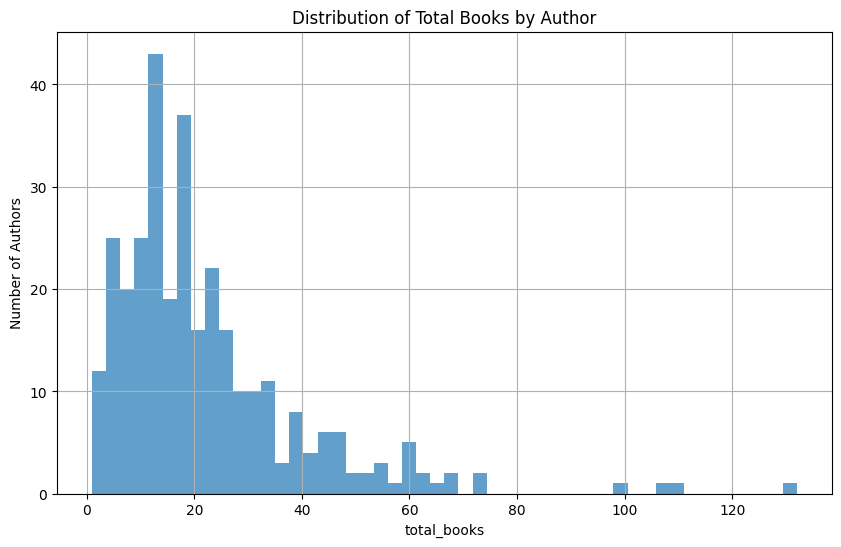

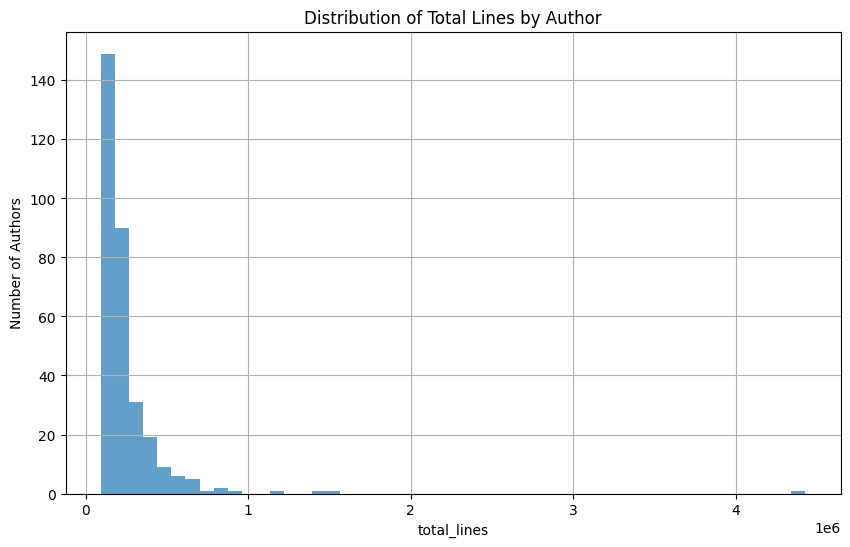

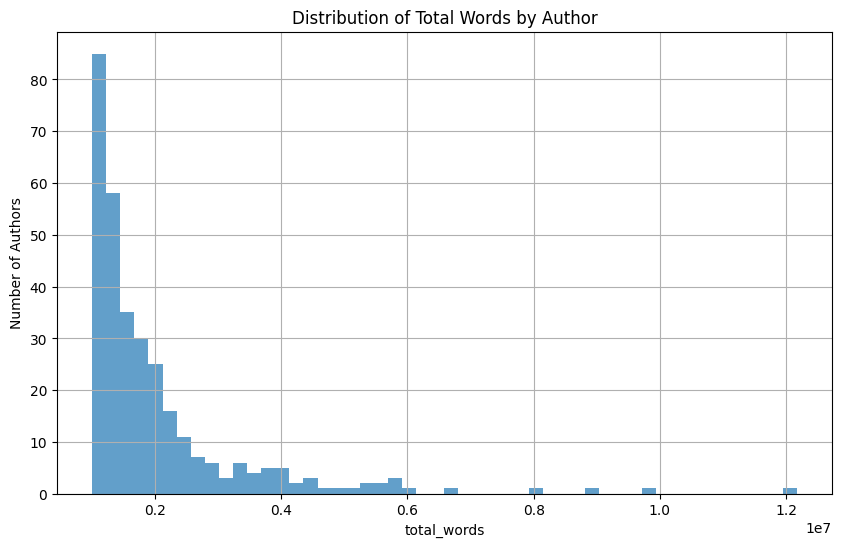

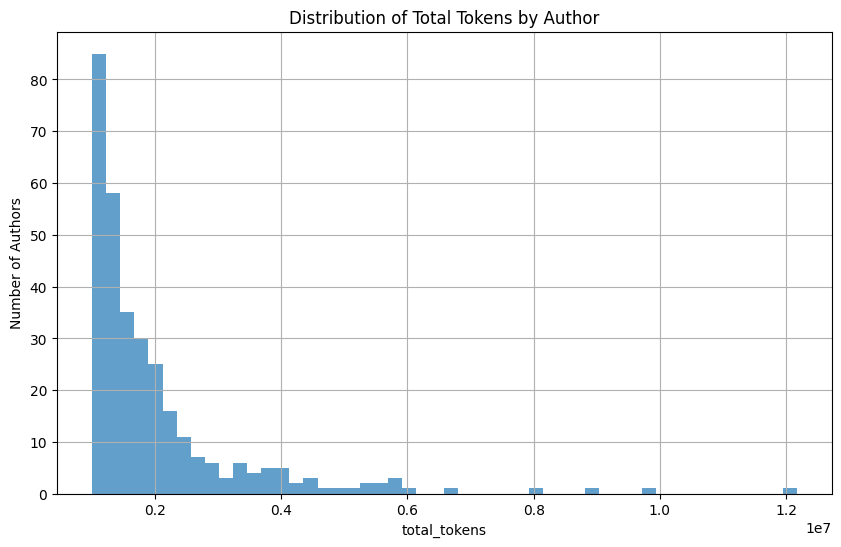

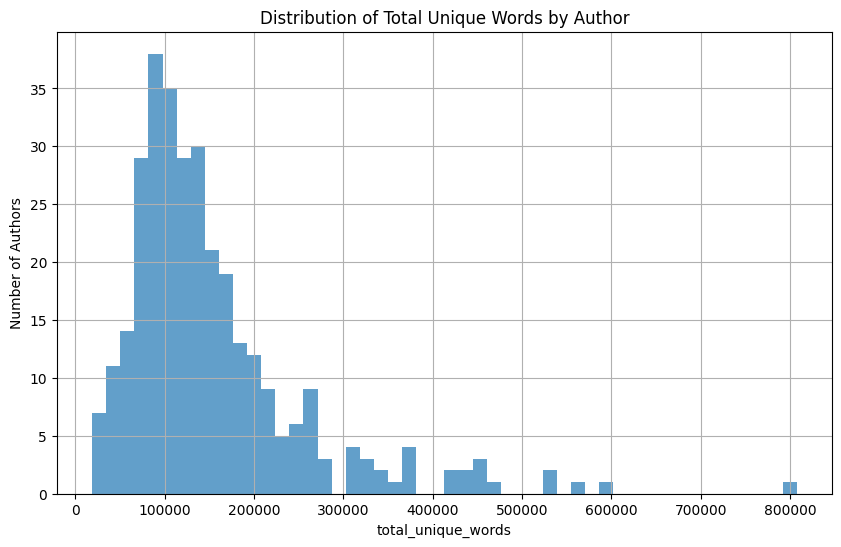

In [201]:
plot_all_author_stat_distributions(author_stat_df2)

In [ ]:
def normalize_df_by_author(df, how='word_count', goal_num=2000000, delta = 100000):
    """
    Makes it so each author has books with the same number of lines (or words, ).
    """
  
    authors = df['author'].unique()
    for author in authors:
        tdf = df[df['author'] == author]
        # Re-add this
        if how == 'book_count':
            num_books = tdf.shape[0]
        else:
            total_count = tdf[how].sum()
        
        if total_count < goal_num - delta:
            df.drop(tdf.index, inplace=True)
        elif total_count > goal_num + delta:
            # Drop books until we reach the goal
            while total_count > goal_num + delta:
                # Find a random book and drop it
                random_book_idx = tdf.sample(1).index[0]
                df.drop(random_book_idx, inplace=True)
                tdf = df[df['author'] == author]
                total_count = tdf[how].sum()

       # elif total_count > goal_num:

      #  total_books, total_lines, total_words, total_tokens, total_unique_words = get_author_stats(df, author)
        
    
    
    return df

In [ ]:
normalize_df_by_author(df, how='line_count', goal_num=10000, delta = 1000)

In [100]:
# What should be the minimum number of books per author?
book_count_cutoff=30

In [ ]:
authors_to_include = vc[vc >= book_count_cutoff].index

mask = df['author'].isin(authors_to_include)
df = df[mask]

In [102]:
df.shape

(3761, 21)

# SETTINGS

In [103]:
df['author'].value_counts().min()

30

In [ ]:
for author, df in new_df.groupby('author'):
    total_lines = df['line_count'].sum()
    total_words = df['word_count'].sum()
    total_tokens = df['token_count'].sum()
    total_unique_words = df['unique_word_count'].sum()
    print(f'{author:30}   lines: {total_lines:10}   words: {total_words:10}   tokens: {total_tokens:10}   unique words: {total_unique_words:10}')
    #print(f'{author:30}   books: {df.shape[1]} )

,Unnamed: 0,id,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,...,type_pgc,Language,Subjects,LoCC,Bookshelves,id_numeric,word_count,unique_word_count,line_count,token_count
46,49,PG10045,"Dave Darrin's Second Year at Annapolis: Or, Tw...","Hancock, H. Irving (Harrie Irving)",1868.0,1922.0,['en'],136,{'United States Naval Academy -- Juvenile fict...,Text,...,Text,en,United States Naval Academy -- Juvenile fiction,PZ,Children's Book Series; Browsing: Children & Y...,10045,36826.0,4235.0,5838.0,36826.0
50,53,PG10049,Old Lady Mary: A Story of the Seen and the Unseen,"Oliphant, Mrs. (Margaret)",1828.0,1897.0,['en'],133,"{'Death -- Fiction', 'Inheritance and successi...",Text,...,Text,en,Inheritance and succession -- Fiction; Death -...,PR,Browsing: Literature; Browsing: Fiction,10049,27179.0,2913.0,2555.0,27179.0
52,55,PG10050,A Little Pilgrim: Stories of the Seen and the ...,"Oliphant, Mrs. (Margaret)",1828.0,1897.0,['en'],90,{'Death -- Fiction'},Text,...,Text,en,Death -- Fiction,PR,Browsing: Literature; Browsing: Fiction,10050,26727.0,2133.0,2412.0,26727.0
53,56,PG10051,The Little Pilgrim: Further Experiences.: Stor...,"Oliphant, Mrs. (Margaret)",1828.0,1897.0,['en'],91,{'Death -- Fiction'},Text,...,Text,en,Death -- Fiction,PR,Browsing: Literature; Browsing: Religion/Spiri...,10051,41714.0,3694.0,3653.0,41714.0
54,57,PG10052,"The Open Door, and the Portrait.: Stories of t...","Oliphant, Mrs. (Margaret)",1828.0,1897.0,['en'],315,{'Manners and customs -- Fiction'},Text,...,Text,en,Manners and customs -- Fiction,PR,Browsing: Culture/Civilization/Society; Browsi...,10052,34078.0,3734.0,3087.0,34078.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56629,75386,PG9785,"Woodstock; or, the Cavalier","Scott, Walter",1771.0,1832.0,['en'],263,"{'Historical fiction', 'Great Britain -- Histo...",Text,...,Text,en,Historical fiction; Great Britain -- History -...,PR,Historical Fiction; Browsing: Culture/Civiliza...,9785,188925.0,12879.0,21447.0,188925.0
56635,75392,PG9790,Traffics and Discoveries,"Kipling, Rudyard",1865.0,1936.0,['en'],290,"{'Short stories, English', 'Armed Forces -- Fi...",Text,...,Text,en,English poetry; Prisoners -- Fiction; Short st...,PR,Browsing: Literature; Browsing: Fiction,9790,80728.0,9138.0,11334.0,80728.0
56700,75469,PG985,Father Sergius,"Tolstoy, Leo, graf",1828.0,1910.0,['en'],656,"{'Monasteries -- Russia -- Fiction', 'Russian ...",Text,...,Text,en,Adultery -- Fiction; Monks -- Fiction; Russia ...,PG,Browsing: Culture/Civilization/Society; Browsi...,985,17071.0,2714.0,1984.0,17071.0
56709,75480,PG986,Master and Man,"Tolstoy, Leo, graf",1828.0,1910.0,['en'],1574,{'Russian fiction -- Translations into English...,Text,...,Text,en,Merchants -- Fiction; Russian fiction -- Trans...,PG,Browsing: Literature; Browsing: Fiction,986,18407.0,2444.0,2180.0,18407.0


In [105]:
#####################
#####################
def normalize_dataset(df, how='num_books'):
    df_books = df.copy()
    author_list = df['author'].unique()
    vc = df['author'].value_counts()

    min_num_books = vc.min()

    for author in author_list:
        tdf = df_books.query('author==@author')
        num_to_drop = tdf.shape[0] - min_num_books
        ind_to_drop = tdf.sample(num_to_drop).index
        df_books.drop(ind_to_drop, inplace=True)
    return df_books


def split_test_train(df, train_perc=0.8):
    author_list = df['author'].unique()
    train_ind = []
    for author in author_list:
        tdf = df.query('author==@author')
        single_author_train_ind = tdf.sample(frac=train_perc).index
        train_ind = [*train_ind,*single_author_train_ind]

    train_df = df.loc[train_ind]
    test_df = df.drop(train_ind)

    return train_df, test_df
    

In [106]:
df['author'].value_counts()

author
Oliphant, Mrs. (Margaret)             132
Jacobs, W. W. (William Wymark)        110
Shakespeare, William                  106
Balzac, Honoré de                      99
Alger, Horatio, Jr.                    74
                                     ... 
Miller, Alex. McVeigh, Mrs.            30
Bower, B. M.                           30
Blanchard, Amy Ella                    30
Aimard, Gustave                        30
Hancock, H. Irving (Harrie Irving)     30
Name: count, Length: 80, dtype: int64

In [107]:
new_df = normalize_dataset(df)

In [108]:
new_df.columns

Index(['Unnamed: 0', 'id', 'title', 'author', 'authoryearofbirth',
       'authoryearofdeath', 'language', 'downloads', 'subjects', 'type',
       'PG_ID', 'type_pgc', 'Language', 'Subjects', 'LoCC', 'Bookshelves',
       'id_numeric', 'word_count', 'unique_word_count', 'line_count',
       'token_count'],
      dtype='object')

In [109]:
new_df['author'].value_counts()

author
Hancock, H. Irving (Harrie Irving)    30
Baum, L. Frank (Lyman Frank)          30
Oliphant, Mrs. (Margaret)             30
Meade, L. T.                          30
Standish, Burt L.                     30
                                      ..
Wharton, Edith                        30
Henty, G. A. (George Alfred)          30
Barbour, Ralph Henry                  30
Davis, Richard Harding                30
Tuttle, W. C. (Wilbur C.)             30
Name: count, Length: 80, dtype: int64

In [110]:
new_df.columns

Index(['Unnamed: 0', 'id', 'title', 'author', 'authoryearofbirth',
       'authoryearofdeath', 'language', 'downloads', 'subjects', 'type',
       'PG_ID', 'type_pgc', 'Language', 'Subjects', 'LoCC', 'Bookshelves',
       'id_numeric', 'word_count', 'unique_word_count', 'line_count',
       'token_count'],
      dtype='object')

In [112]:
for author, df in new_df.groupby('author'):
    total_lines = df['line_count'].sum()
    total_words = df['word_count'].sum()
    total_tokens = df['token_count'].sum()
    total_unique_words = df['unique_word_count'].sum()
    print(f'{author:30}   lines: {total_lines:10}   words: {total_words:10}   tokens: {total_tokens:10}   unique words: {total_unique_words:10}')
    #print(f'{author:30}   books: {df.shape[1]} )

A. L. O. E.                      lines:   110578.0   words:   911723.0   tokens:   911723.0   unique words:   116463.0
Aimard, Gustave                  lines:   337624.0   words:  2595934.0   tokens:  2595934.0   unique words:   209211.0
Alger, Horatio, Jr.              lines:   235715.0   words:  1401653.0   tokens:  1401653.0   unique words:   127570.0
Balzac, Honoré de                lines:   169645.0   words:  1488643.0   tokens:  1488643.0   unique words:   161088.0
Barbour, Ralph Henry             lines:   214281.0   words:  1658885.0   tokens:  1658885.0   unique words:   161680.0
Baring-Gould, S. (Sabine)        lines:   281160.0   words:  2309133.0   tokens:  2309133.0   unique words:   241036.0
Baum, L. Frank (Lyman Frank)     lines:   177031.0   words:  1318930.0   tokens:  1318930.0   unique words:   144007.0
Belloc, Hilaire                  lines:   163942.0   words:  1453177.0   tokens:  1453177.0   unique words:   154188.0
Bennett, Arnold                  lines:   220023

In [63]:
new_df.shape

(3744, 21)

In [ ]:
train_df, test_df = split_test_train(df)

In [ ]:
train_df

In [ ]:
test_df

In [ ]:
def write_csv_in_metadata_format(df, outfile):
    cols_to_keep = ['id', 'title', 'author', 'authoryearofbirth', 'authoryearofdeath',
       'language', 'downloads', 'subjects']
    df = df[cols_to_keep]
    df.to_csv(outfile)

In [ ]:
train_outfile = 'train.csv'
test_outfile = 'test.csv'
write_csv_in_metadata_format(train_df, train_outfile)
write_csv_in_metadata_format(test_df, test_outfile)